<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Kamis, 18 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [1]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 290 kB 10.1 MB/s 
     |████████████████████████████████| 3.1 MB 48.7 MB/s 
     |████████████████████████████████| 243 kB 49.8 MB/s 
     |████████████████████████████████| 1.1 MB 31.7 MB/s 
     |████████████████████████████████| 59 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 60.0 MB/s 
     |████████████████████████████████| 3.3 MB 58.6 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 895 kB 58.0 MB/s 
     |████████████████████████████████| 271 kB 56.3 MB/s 
     |████████████████████████████████| 192 kB 49.9 MB/s 
     |████████████████████████████████| 160 kB 74.7 MB/s 


In [2]:
!pip install tez

In [3]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [4]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [6]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [7]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [8]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [9]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [10]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [11]:
train_oh_labels.shape

(43410, 28)

In [12]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [13]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [14]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


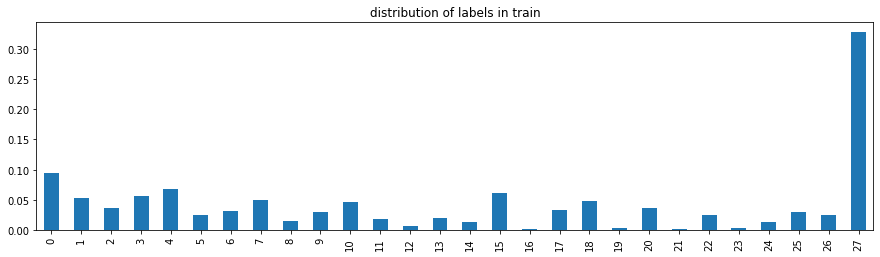

In [15]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

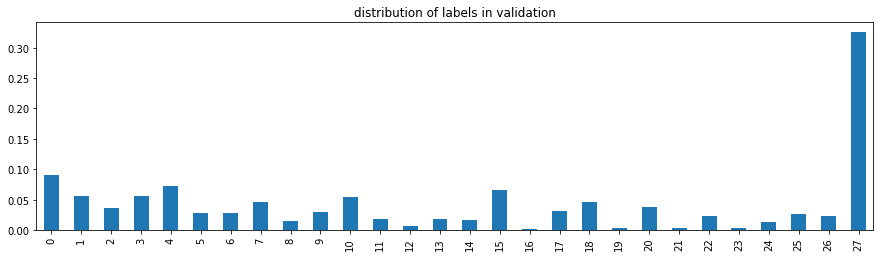

In [16]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

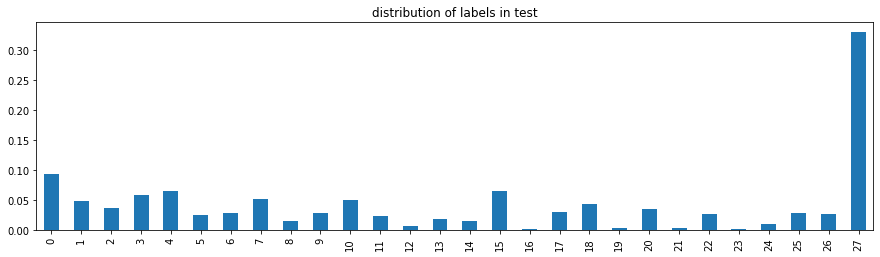

In [17]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [18]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [19]:
inspect_data(0)

examples from admiration

Yo this is actually awesome storytelling and also if I were you I would have clocked [NAME] into next week. Just sayin.
---
I make my cows super stronk.
---
I'm sure the guy posting is this just gorgeous with the best personality ever
---
Awesome - welcome aboard and tell your friends!
---
It's prevalent in everything. WoW was incredible when it came out *because* everyone was garbage.
---


In [20]:
inspect_data(1)

examples from amusement

Steeler 4 life lol
---
Anything is a dildo of you're brave enough
---
Yay! Mine’s Cymbalta and Lamictal with a dash of Ativan lol
---
You goatta be kidding me!
---
No another person lol.
---


In [21]:
inspect_data(2)

examples from anger

Just throw them into a pool of needles. That'll teach them not to steal ever again.
---
Bitch yes!
---
> and no one but angry community fanboys have pushed back against his statements.
---
Don't you know? We have to just shut up and put our heads down until they decide!
---
lakers bout to get KAT fucked now
---


In [22]:
inspect_data(3)

examples from annoyance

Lol the fact that actual fans can't afford tickets is why there are let's go heat chants at this game
---
You finna be nauseous as hell man, Dont stress it though just throw up
---
*I curse you to an eternity of walking barefoot on a world of Lego!*
---
How many shitposts does it take to make me unsub
---
And if that's the case then there is no helping him. It sucks that those people can't be helped
---


In [23]:
inspect_data(4)

examples from approval

Yes, we'll see! On a separate note, when I read your user name at first glance I thought it was "ItGetsThroughBoner".
---
He isn't always. But right now. Shoot the ball whenever you want Young blood. Go head.
---
Yes that is so true why didn’t I think of that
---
He's both. An edgy neckbeard skinny fat, but he is undeniably funny. 
---
That's what you get when you stretch a series for too long.... "Ohhh gee....welp.... another one....."
---


In [24]:
inspect_data(5)

examples from caring

She has a disorder of sorts. Not only do you both need counseling, but she needs some kind of therapy. 
---
Whiskey isn't going to help. She should pray to [NAME] that another man comes and brings purpose to her life.
---
I'm concerned they actually have to press a button. Why no dead man's handle?
---
Good luck bro! I am with you on this journey. Currently on day 7. I had trouble sleeping yesterday night due to the urges.
---
Don’t worry! I was never convicted of anything!
---


**Menetukan kumpulan data PyTorch**

In [25]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

**Mendefinisikan Tez** 

In [26]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

In [27]:
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

In [28]:
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())

In [29]:
def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}

In [30]:
def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc